# SPEAKER IDENTIFICATION
CNN on Librispeech

In [1]:
import os
from pathlib import Path

%matplotlib inline
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd

import soundfile

from tensorflow.keras.callbacks import TensorBoard

In [2]:
source   = "NEW_Librispeech_SUBSET"


train_file = "Librispeech_train70.csv"
with open(train_file, 'r') as file:
    file_paths_train = [line.strip() for line in file.readlines()]

list_ds_train = tf.data.Dataset.from_tensor_slices(file_paths_train)

test_file = "Librispeech_test20.csv"
with open(test_file, 'r') as file:
    file_paths_test = [line.strip() for line in file.readlines()]

list_ds_test = tf.data.Dataset.from_tensor_slices(file_paths_test)

val_file = "Librispeech_val10.csv"
with open(val_file, 'r') as file:
    file_paths_val = [line.strip() for line in file.readlines()]

list_ds_val = tf.data.Dataset.from_tensor_slices(file_paths_val)

## get names

In [3]:
def extract_speaker(file_path):
    sc = tf.strings.split(file_path, '.')[0] #[0]
    sc = tf.strings.split(sc, '-')[0]
    print(sc)
    return sc

In [4]:
speaker_ds_test = list_ds_test.map(extract_speaker)
speaker_ds_val = list_ds_val.map(extract_speaker)
speaker_ds_train = list_ds_train.map(extract_speaker)


Tensor("strided_slice_1:0", shape=(), dtype=string)
Tensor("strided_slice_1:0", shape=(), dtype=string)
Tensor("strided_slice_1:0", shape=(), dtype=string)


In [5]:
def path_speaker(file_path):
    source   = "NEW_Librispeech_SUBSET/"
    sc =  tf.strings.split(file_path)[0]  #[0]
    return source + sc

In [6]:
path_ds_test = list_ds_test.map(path_speaker)
for f in path_ds_test.take(3):
    print(f.numpy())

b'NEW_Librispeech_SUBSET/19-227-0042.flac'
b'NEW_Librispeech_SUBSET/19-227-0043.flac'
b'NEW_Librispeech_SUBSET/19-227-0044.flac'


In [7]:
path_ds_val = list_ds_val.map(path_speaker)
for f in path_ds_val.take(3):
    print(f.numpy())

b'NEW_Librispeech_SUBSET/19-227-0035.flac'
b'NEW_Librispeech_SUBSET/19-198-0035.flac'
b'NEW_Librispeech_SUBSET/19-227-0036.flac'


In [8]:
path_ds_train = list_ds_train.map(path_speaker)
for f in path_ds_train.take(3):
    print(f.numpy())

b'NEW_Librispeech_SUBSET/19-227-0000.flac'
b'NEW_Librispeech_SUBSET/19-198-0000.flac'
b'NEW_Librispeech_SUBSET/19-227-0001.flac'


## Encoder for audios and names

In [9]:
# create one-hot vector dataset from speakers
speaker_encoder = preprocessing.LabelEncoder() # create encoder
speaker_idx_test = speaker_encoder.fit_transform([bytes.decode(s.numpy()) for s in speaker_ds_test]) #fit decoded index(01)
encoded_speaker_ds_test = tf.data.Dataset.from_tensor_slices(speaker_idx_test) #dataset of encoded index
unique_speakers = len(speaker_encoder.classes_)

unique_speakers

81

In [10]:
speaker_idx_test

array([18, 18, 18, ..., 78, 78, 78], dtype=int64)

In [11]:
speaker_idx_train = speaker_encoder.fit_transform([bytes.decode(s.numpy()) for s in speaker_ds_train]) #fit decoded index(01)
encoded_speaker_ds_train = tf.data.Dataset.from_tensor_slices(speaker_idx_train) #dataset of encoded index
unique_speakers = len(speaker_encoder.classes_)

unique_speakers

81

In [12]:
speaker_idx_train.shape

(5670,)

In [13]:
speaker_idx_val = speaker_encoder.fit_transform([bytes.decode(s.numpy()) for s in speaker_ds_val]) #fit decoded index(01)
encoded_speaker_ds_val = tf.data.Dataset.from_tensor_slices(speaker_idx_val) #dataset of encoded index
unique_speakers = len(speaker_encoder.classes_)

unique_speakers

81

In [14]:
speaker_idx_val.shape

(810,)

In [15]:
def wav2mfcc(file_path, max_pad_len=196): #extracting the mfcc
    ''' convert wav file to mfcc matrix with truncation and padding '''
    wave, sample_rate = librosa.load(file_path, mono=True, sr=None)  # READ the wav file
    mfcc = librosa.feature.mfcc(y=wave, sr = sample_rate) #get mfcc with librosa library
    mfcc = mfcc[:, :max_pad_len] #truncate the mfcc to 196 samples
    pad_width = max_pad_len - mfcc.shape[1]  # to pad in case not enought samples 
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant') # pad constant (0)
    return mfcc

In [16]:
def extract_mfcc(file_path): # creating a tensor of -mfcc
    ''' returns 3D tensor of the mfcc coding from the wav file '''
    file_name = bytes.decode(file_path.numpy()) #decode file path as file name
    mfcc = tf.convert_to_tensor(wav2mfcc(file_name)) #create a tensor of mfcc
    mfcc = tf.expand_dims(mfcc, 2) #index 2   https://www.tensorflow.org/api_docs/python/tf/expand_dims
    return mfcc

In [17]:
def create_audio_ds(list_ds): #create a dataset of MFCC
    ''' creates audio dataset containing audio tensors from file list dataset '''
    batch = []
    for f in list_ds: # in the list with the paths
        print(f)
        audio = extract_mfcc(f) # extracting MFCC
        batch.append(audio)
    return tf.data.Dataset.from_tensor_slices(batch) #Dataset of MFCC

In [18]:
%time audio_ds_test = create_audio_ds(path_ds_test)
%time audio_ds_val = create_audio_ds(path_ds_val)
%time audio_ds_train = create_audio_ds(path_ds_train) #create a dataset of MFCC

tf.Tensor(b'NEW_Librispeech_SUBSET/19-227-0042.flac', shape=(), dtype=string)
tf.Tensor(b'NEW_Librispeech_SUBSET/19-227-0043.flac', shape=(), dtype=string)
tf.Tensor(b'NEW_Librispeech_SUBSET/19-227-0044.flac', shape=(), dtype=string)
tf.Tensor(b'NEW_Librispeech_SUBSET/19-227-0045.flac', shape=(), dtype=string)
tf.Tensor(b'NEW_Librispeech_SUBSET/19-227-0046.flac', shape=(), dtype=string)
tf.Tensor(b'NEW_Librispeech_SUBSET/19-227-0047.flac', shape=(), dtype=string)
tf.Tensor(b'NEW_Librispeech_SUBSET/19-227-0048.flac', shape=(), dtype=string)
tf.Tensor(b'NEW_Librispeech_SUBSET/19-227-0049.flac', shape=(), dtype=string)
tf.Tensor(b'NEW_Librispeech_SUBSET/19-227-0050.flac', shape=(), dtype=string)
tf.Tensor(b'NEW_Librispeech_SUBSET/19-227-0051.flac', shape=(), dtype=string)
tf.Tensor(b'NEW_Librispeech_SUBSET/19-227-0052.flac', shape=(), dtype=string)
tf.Tensor(b'NEW_Librispeech_SUBSET/19-227-0053.flac', shape=(), dtype=string)
tf.Tensor(b'NEW_Librispeech_SUBSET/19-227-0054.flac', shape=(), 

In [19]:
# Audio (input) tensor is 3D tensor.
# 20x196 is MFCC encoding. Converting it to 3D for use in CNN layers.
for a in audio_ds_test.take(1):
    print(a.numpy().shape)

(20, 196, 1)


In [20]:
for a in audio_ds_train.take(1):
    print(a.numpy().shape)

(20, 196, 1)


In [21]:
for a in audio_ds_val.take(1):
    print(a.numpy().shape)

(20, 196, 1)


In [22]:
#Zip the input and labels to a single dataset.
labeled_ds_test = tf.data.Dataset.zip((audio_ds_test, encoded_speaker_ds_test))
labeled_ds_train = tf.data.Dataset.zip((audio_ds_train, encoded_speaker_ds_train))
labeled_ds_val = tf.data.Dataset.zip((audio_ds_val, encoded_speaker_ds_val))


In [23]:
input_shape = None
for audio, speaker in labeled_ds_test.take(1):
    input_shape = audio.shape
    print('input_shape', audio.shape)
    print('output_shape', speaker.shape)

input_shape (20, 196, 1)
output_shape ()


In [24]:
# create train, validation and test datasets.

train_size = sum([1 for _ in labeled_ds_train])
val_size = sum([1 for _ in labeled_ds_val])
test_size = sum([1 for _ in labeled_ds_test])
data_size = train_size+val_size+test_size
print('all samples: {}'.format(data_size))
print('training samples: {}'.format(train_size))
print('validation samples: {}'.format(val_size))
print('test samples: {}'.format(test_size))

all samples: 8100
training samples: 5670
validation samples: 810
test samples: 1620


In [25]:
# create batched datasets
batch_size = 32
train_ds = labeled_ds_train.shuffle(train_size, seed=42, reshuffle_each_iteration=False).batch(batch_size)
val_ds = labeled_ds_val.shuffle(val_size, seed=42, reshuffle_each_iteration=False).batch(batch_size)
test_ds = labeled_ds_test.shuffle(test_size, seed=42, reshuffle_each_iteration=False).batch(batch_size)

In [26]:
def create_model():
    
    dropout_rate = .25
    regularazation = 0.001
    
    audio_input = keras.layers.Input(shape=input_shape)
    
    conv1 = keras.layers.Conv2D(16, kernel_size=(3, 3), padding='same',
                               activation='relu', input_shape=input_shape)(audio_input)
    maxpool1 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv1)
    batch1 = keras.layers.BatchNormalization()(maxpool1)
    
    conv2 = keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same',
                               activation='relu', input_shape=input_shape)(batch1)
    maxpool2 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv2)
    batch2 = keras.layers.BatchNormalization()(maxpool2)
    
    conv3 = keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', 
                activation='relu')(batch2)
    maxpool3 = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv3)
    batch3 = keras.layers.BatchNormalization()(maxpool3)
    
    flt = keras.layers.Flatten()(batch3)
    
    drp1 = keras.layers.Dropout(dropout_rate)(flt)
    
    dense1 = keras.layers.Dense(unique_speakers * 2, activation='relu',
                kernel_regularizer=keras.regularizers.l2(regularazation))(drp1)
    
    drp2 = keras.layers.Dropout(dropout_rate)(dense1)
    
    output = keras.layers.Dense(unique_speakers, activation='softmax', name='speaker')(drp2)
    
    model = keras.Model(inputs=audio_input, outputs=output)
    model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['acc', 'sparse_top_k_categorical_accuracy'])
    return model

In [27]:
train_model = False
model_name = 'spr_model_2_70-10-20.h5'
model_path = os.path.join('.', model_name)
model = None
model = create_model()
train_model = True

In [28]:
model.summary()  

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 196, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 196, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 98, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 10, 98, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 98, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 49, 32)        0     

In [29]:
history = {}

tf.keras.metrics.TopKCategoricalAccuracy(
    k=1, name='top_k_categorical_accuracy', dtype=None
)
if train_model:
    root_logdir = os.path.join(os.curdir, "spr_logs")
    def get_run_dir():
        import time
        run_id = time.strftime("run%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)
    run_logdir = get_run_dir()
    tensorboard_cb = keras.callbacks.TensorBoard(run_logdir, update_freq='batch')
    history = model.fit(train_ds, epochs=8, validation_data=val_ds, callbacks=[tensorboard_cb])
    
    

Epoch 1/8
178/178 [==============================] - 27s 139ms/step - loss: 3.6318 - acc: 0.2058 - sparse_top_k_categorical_accuracy: 0.4259 - val_loss: 2.6684 - val_acc: 0.3605 - val_sparse_top_k_categorical_accuracy: 0.6914
Epoch 2/8
178/178 [==============================] - 13s 71ms/step - loss: 1.3849 - acc: 0.6945 - sparse_top_k_categorical_accuracy: 0.9249 - val_loss: 0.9445 - val_acc: 0.8247 - val_sparse_top_k_categorical_accuracy: 0.9691
Epoch 3/8
178/178 [==============================] - 13s 73ms/step - loss: 0.7688 - acc: 0.8760 - sparse_top_k_categorical_accuracy: 0.9875 - val_loss: 0.6719 - val_acc: 0.9000 - val_sparse_top_k_categorical_accuracy: 0.9926
Epoch 4/8
178/178 [==============================] - 13s 71ms/step - loss: 0.5812 - acc: 0.9337 - sparse_top_k_categorical_accuracy: 0.9958 - val_loss: 0.6421 - val_acc: 0.9173 - val_sparse_top_k_categorical_accuracy: 0.9864
Epoch 5/8
178/178 [==============================] - 29s 165ms/step - loss: 0.4984 - acc: 0.9598 - 

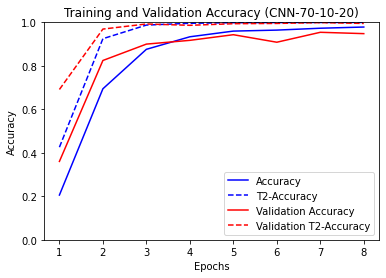

In [30]:
plt.clf()
plt.rcParams.update(plt.rcParamsDefault)
# Access the accuracy values from the training history
T1_accuracy = history.history['acc']
T1_val_accuracy = history.history['val_acc']
T2_accuracy = history.history['sparse_top_k_categorical_accuracy']
T2_val_accuracy = history.history['val_sparse_top_k_categorical_accuracy']

# Plot the accuracy values
epochs = range(1, len(T1_accuracy) + 1)
plt.plot(epochs, T1_accuracy, 'b', label='Accuracy')
plt.plot(epochs, T2_accuracy, 'b', label='T2-Accuracy', linestyle = "--")
plt.plot(epochs, T1_val_accuracy, 'r', label='Validation Accuracy')
plt.plot(epochs, T2_val_accuracy, 'r', label='Validation T2-Accuracy', linestyle = "--")
plt.title(f'Training and Validation Accuracy (CNN-70-10-20)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()

plt.savefig(f"Librispeech_Training and Validation Accuracy (CNN-70-10-20).png")

In [31]:
model.evaluate(test_ds)

51/51 [==============================] - 1s 18ms/step - loss: 0.5015 - acc: 0.9352 - sparse_top_k_categorical_accuracy: 0.9969


[0.5015033483505249, 0.9351851940155029, 0.9969135522842407]

In [32]:
# Make predictions on the test dataset
y_pred = model.predict(test_ds)

# Obtain top 1 and top 2 predictions
top_2 = np.argsort(-y_pred, axis=1)[:, :2] 

# Get the actual values from the test dataset
y = np.concatenate([y for x, y in test_ds], axis=0)

# Create a DataFrame from y and top_2
data = {'Test_y': y, 'Top_2_1': top_2[:, 0], 'Top_2_2': top_2[:, 1]}
results = pd.DataFrame(data)

#results.to_excel('y_CNN_3.xlsx', sheet_name='CNN_3')


51/51 [==============================] - 1s 17ms/step


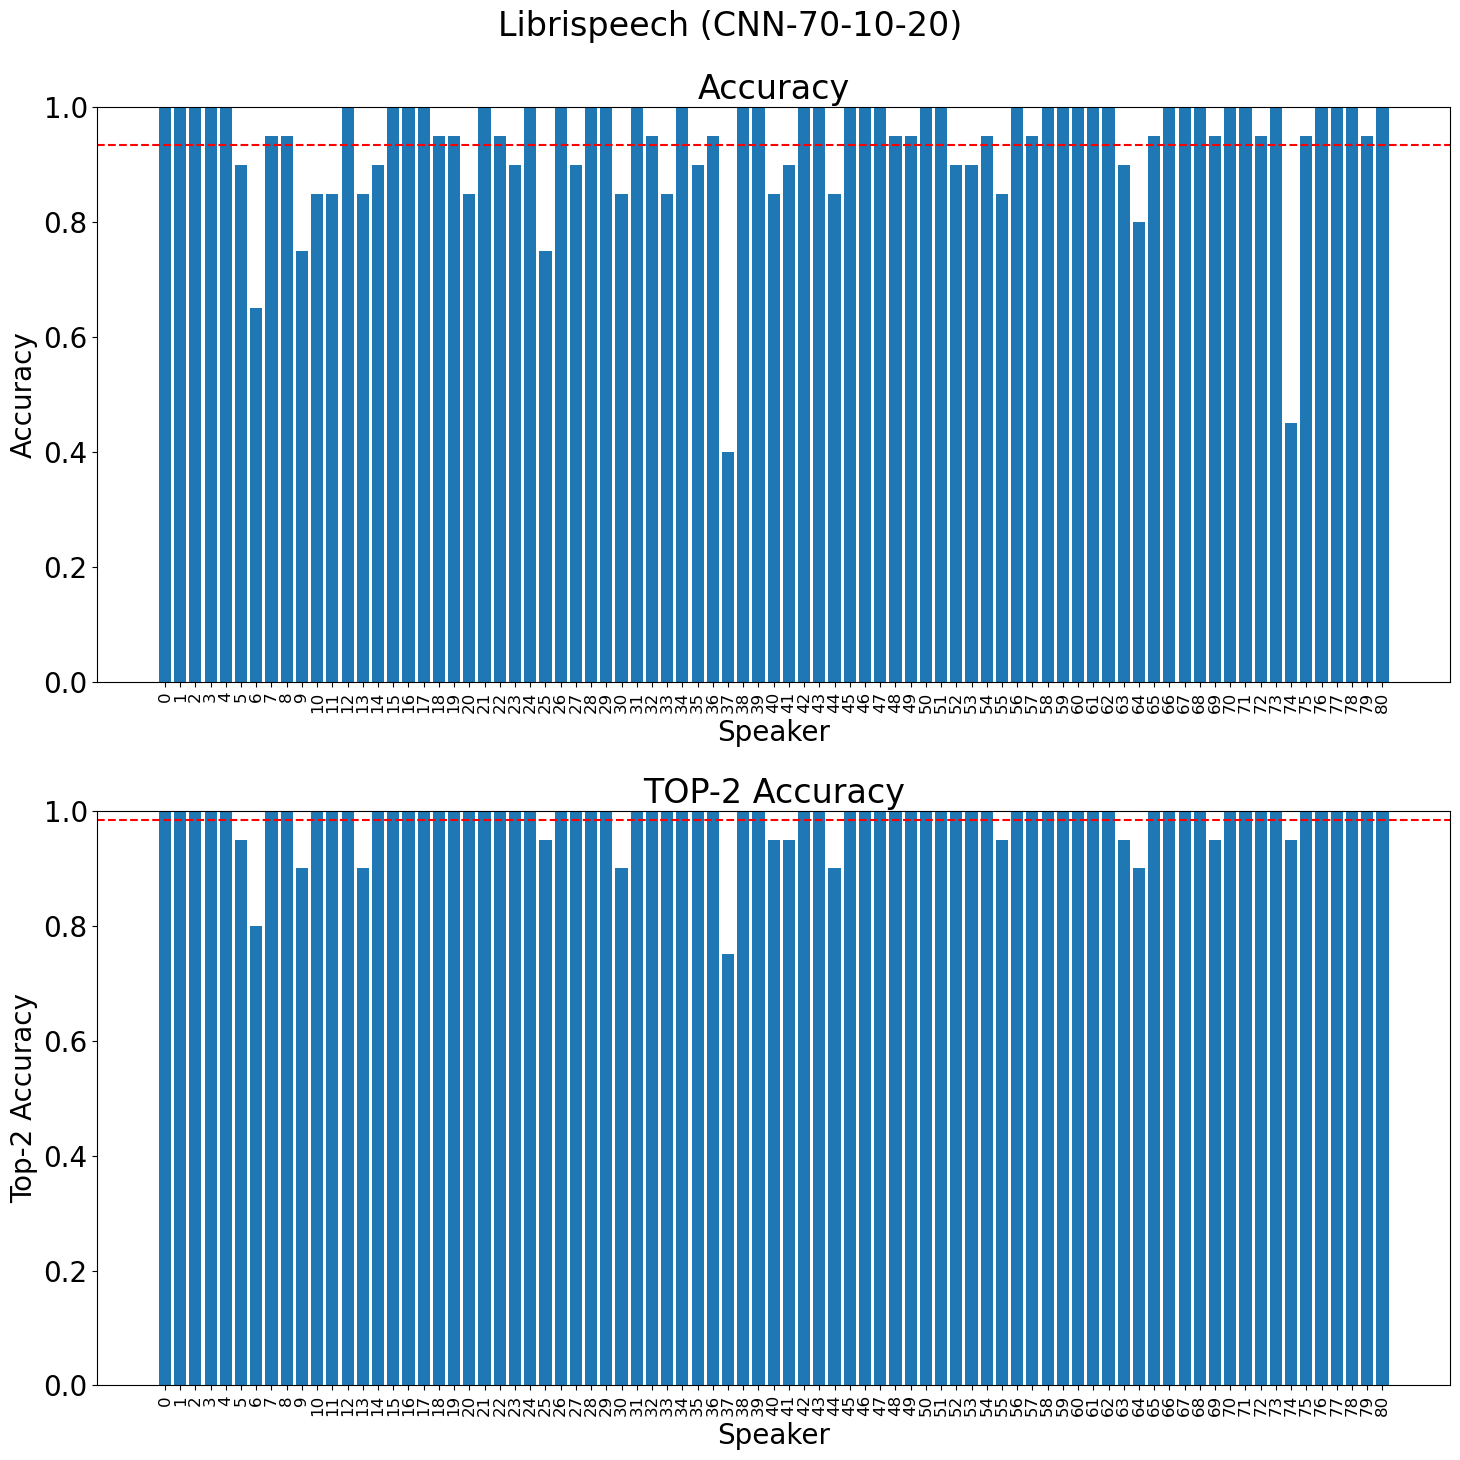

In [33]:
# Load the results DataFrame as df
df = results
plt.rcParams['font.size'] = 20

# Calculate accuracy for matching Test_y and Top_2_1
results["acc_1"] = (df['Test_y'] == df['Top_2_1'])

# Calculate accuracy for matching Test_y and (Top_2_1 & Top_2_2)
results["acc_2"]  = ((df['Test_y'] == df['Top_2_1']) | (df['Test_y'] == df['Top_2_2']))

# Get unique values of Test_y
unique_values = df['Test_y'].unique()

mean_accuracy = results.groupby(df['Test_y'])[['acc_1', 'acc_2']].mean().reset_index()
mean_accuracy.set_index(mean_accuracy.columns[0], inplace=True)

# Get the speaker names
speakers = mean_accuracy.index

# Create bar plots
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
plt.suptitle(f"Librispeech (CNN-70-10-20)")

axs[0].bar(range(len(speakers)), mean_accuracy['acc_1'])
axs[0].axhline(mean_accuracy['acc_1'].mean(), color='r', linestyle='--')
axs[0].set_xlabel('Speaker')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xticks(range(len(speakers)))
axs[0].set_ylim([0,1])
axs[0].set_xticklabels(speakers, rotation=90, fontsize=12)

axs[1].bar(range(len(speakers)), mean_accuracy['acc_2'])
axs[1].axhline(mean_accuracy['acc_2'].mean(), color='r', linestyle='--')
axs[1].set_xlabel('Speaker')
axs[1].set_ylabel('Top-2 Accuracy')
axs[1].set_title('TOP-2 Accuracy')
axs[1].set_xticks(range(len(speakers)))
axs[1].set_ylim([0,1])
axs[1].set_xticklabels(speakers, rotation=90, fontsize=12)

#fig.suptitle(f"AudioMNIST_(TRAIN {100*train_size/data_size}%)", fontsize=26)
plt.tight_layout()


# Display the plot

plt.savefig("Librispeech_(CNN-70-10-20).png")

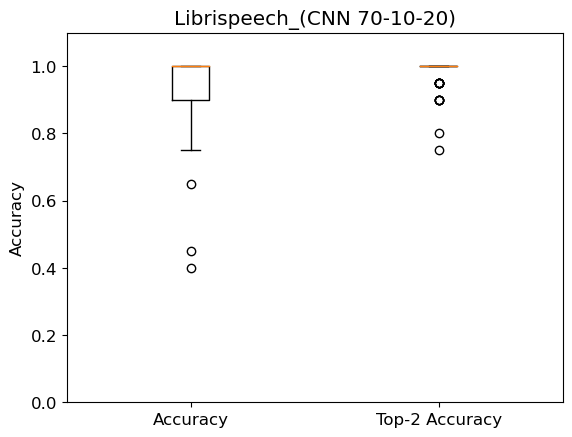

In [34]:
plt.rcParams['font.size'] = 12
# Create a figure and axis
fig, ax = plt.subplots()

# Create a list of the two data series for box plots
data = [mean_accuracy['acc_1'], mean_accuracy['acc_2']]

# Create the box plots
box_plot = ax.boxplot(data, labels=['Accuracy', 'Top-2 Accuracy'])

# Add labels to the box plots
ax.set_ylabel('Accuracy')
ax.set_title(f"Librispeech_(CNN 70-10-20)")
ax.set_ylim([0, 1.1])

# Display the plot

plt.savefig(f"Librispeech_(CNN 70-10-20)_BP.png")

In [35]:
if train_model:
    model.save(model_name)

In [36]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)
y_train = np.concatenate([y for x, y in train_ds], axis=0)

# Create an ExcelWriter object
writer = pd.ExcelWriter('y_data_CNN3.xlsx')

# Save y_test in a sheet named 'test'
df_test = pd.DataFrame(y_test)
df_test.to_excel(writer, sheet_name='test', index=False)

# Save y_val in a sheet named 'val'
df_val = pd.DataFrame(y_val)
df_val.to_excel(writer, sheet_name='val', index=False)

# Save y_train in a sheet named 'train'
df_train = pd.DataFrame(y_train)
df_train.to_excel(writer, sheet_name='train', index=False)

# Save and close the ExcelWriter
writer.save()

